# 1. Load libraries and dataset

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import ks_2samp
from kneed import KneeLocator

In [4]:
# Load data
# Transaction-level data
addr_tx_in = pd.read_csv("./data/AddrTx_edgelist.csv")
tx_addr_out = pd.read_csv("./data/TxAddr_edgelist.csv")

tx_features = pd.read_csv("./data/txs_features.csv")
tx_classes = pd.read_csv("./data/txs_classes.csv")
tx_edges = pd.read_csv("./data/txs_edgelist.csv")

## 1.1 Dataset structure

- wallet_df: features and classes of wallets

- tx_features & tx_classes: features and classes of transactions

- tx_edges: links transactions to each other for transaction-level network analysis

- addr_tx_in & tx_addr_out: bipartite relations between transactions and addresses

- addr_addr_edges: links addresses to each other for wallet-level analysis



In [5]:
# Get shapes of the datasets
print('Shape of classes:', tx_classes.shape)
print('Shape of edgelist:', tx_edges.shape)
print('Shape of features:', tx_features.shape)
print('Shape of addr tx edges:', addr_tx_in.shape)
print('Shape of tx addr edges:', tx_addr_out.shape)

Shape of classes: (203769, 2)
Shape of edgelist: (234355, 2)
Shape of features: (203769, 184)
Shape of addr tx edges: (477117, 2)
Shape of tx addr edges: (837124, 2)


In [6]:
tx_features.columns.tolist()

['txId',
 'Time step',
 'Local_feature_1',
 'Local_feature_2',
 'Local_feature_3',
 'Local_feature_4',
 'Local_feature_5',
 'Local_feature_6',
 'Local_feature_7',
 'Local_feature_8',
 'Local_feature_9',
 'Local_feature_10',
 'Local_feature_11',
 'Local_feature_12',
 'Local_feature_13',
 'Local_feature_14',
 'Local_feature_15',
 'Local_feature_16',
 'Local_feature_17',
 'Local_feature_18',
 'Local_feature_19',
 'Local_feature_20',
 'Local_feature_21',
 'Local_feature_22',
 'Local_feature_23',
 'Local_feature_24',
 'Local_feature_25',
 'Local_feature_26',
 'Local_feature_27',
 'Local_feature_28',
 'Local_feature_29',
 'Local_feature_30',
 'Local_feature_31',
 'Local_feature_32',
 'Local_feature_33',
 'Local_feature_34',
 'Local_feature_35',
 'Local_feature_36',
 'Local_feature_37',
 'Local_feature_38',
 'Local_feature_39',
 'Local_feature_40',
 'Local_feature_41',
 'Local_feature_42',
 'Local_feature_43',
 'Local_feature_44',
 'Local_feature_45',
 'Local_feature_46',
 'Local_feature_47',

In [7]:
# Data Preprocessing
# Merge tx features + classes (labels) and rename columns for accessibility
tx_df = tx_features.merge(tx_classes, on="txId", how="left")
tx_df["class_mapped"] = tx_df["class"].replace({1: "illicit", 2: "licit", 3: "unknown"})
tx_df = tx_df.rename(columns={"txId": "tx_id", "Time step": "time_step"})

addr_tx_in = addr_tx_in.rename(columns={'txId': 'tx_id', 'input_address': 'address'})
tx_addr_out = tx_addr_out.rename(columns={'txId': 'tx_id', 'output_address': 'address'})

# 2. EDA on base datasets


## 2.1 Class distribution in transaction-level datasets

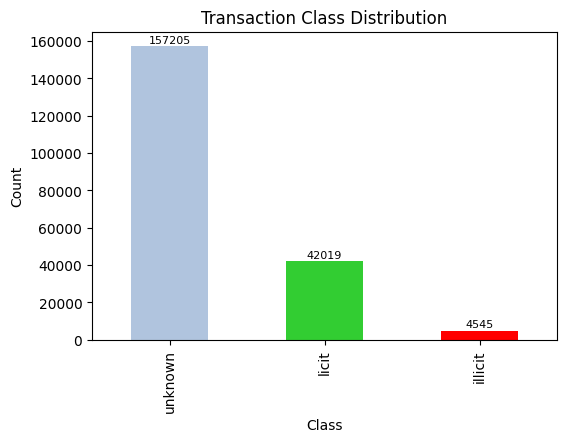

In [8]:
# Class distribution for transactions
plt.figure(figsize=(6,4))
ax = tx_df["class_mapped"].value_counts().plot(kind="bar", color=["lightsteelblue","limegreen","red"])
plt.title("Transaction Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
# Add count labels
for p in ax.patches:
    ax.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width()/2, p.get_height()),
        ha='center', va='bottom', fontsize=8, color='black', xytext=(0, 1),
        textcoords='offset points'
    )

plt.show()

From the plots above, we can see that a large proportion of the data in the datasets are classified as "unknown".

In the **transaction-level** dataset, 157205 (77.15%) of the data are labelled "unknown", 42019 (20.62%) of the data are labelled "licit", and 4545 (2.23%) of the data are labelled "illicit".

In the dataset, more than half the data are "unknown", and less than 3% of the data are labelled "illicit", which might pose a problem when training the model due to the large imbalance in data. -> can try focal loss?

## 2.2 Proportion of labelled transactions over time steps

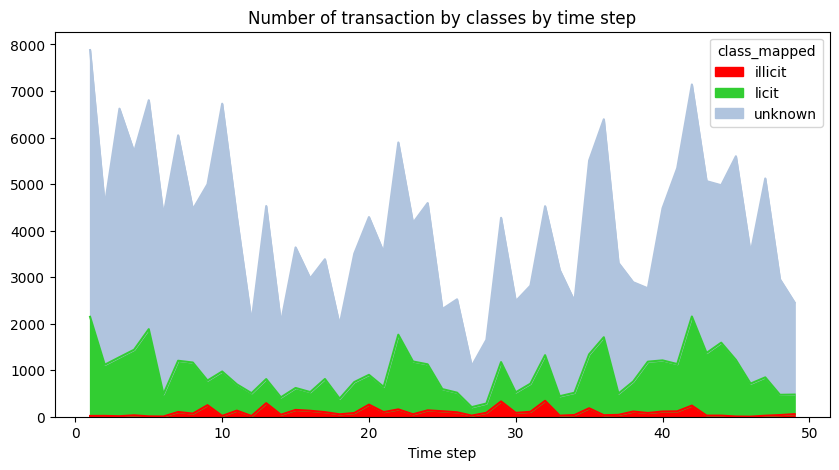

In [9]:
# Proportion of licit/ illicit transactions over time
time_counts = tx_df.groupby('time_step')['class_mapped'].value_counts().unstack().fillna(0)
time_counts.plot(
    kind='area', color=["red","limegreen","lightsteelblue"],
    stacked=True, figsize=(10,5),
    title='Number of transaction by classes by time step',
    xlabel='Time step'
    )
plt.show()

## 2.3 Transaction-level feature distribution EDA

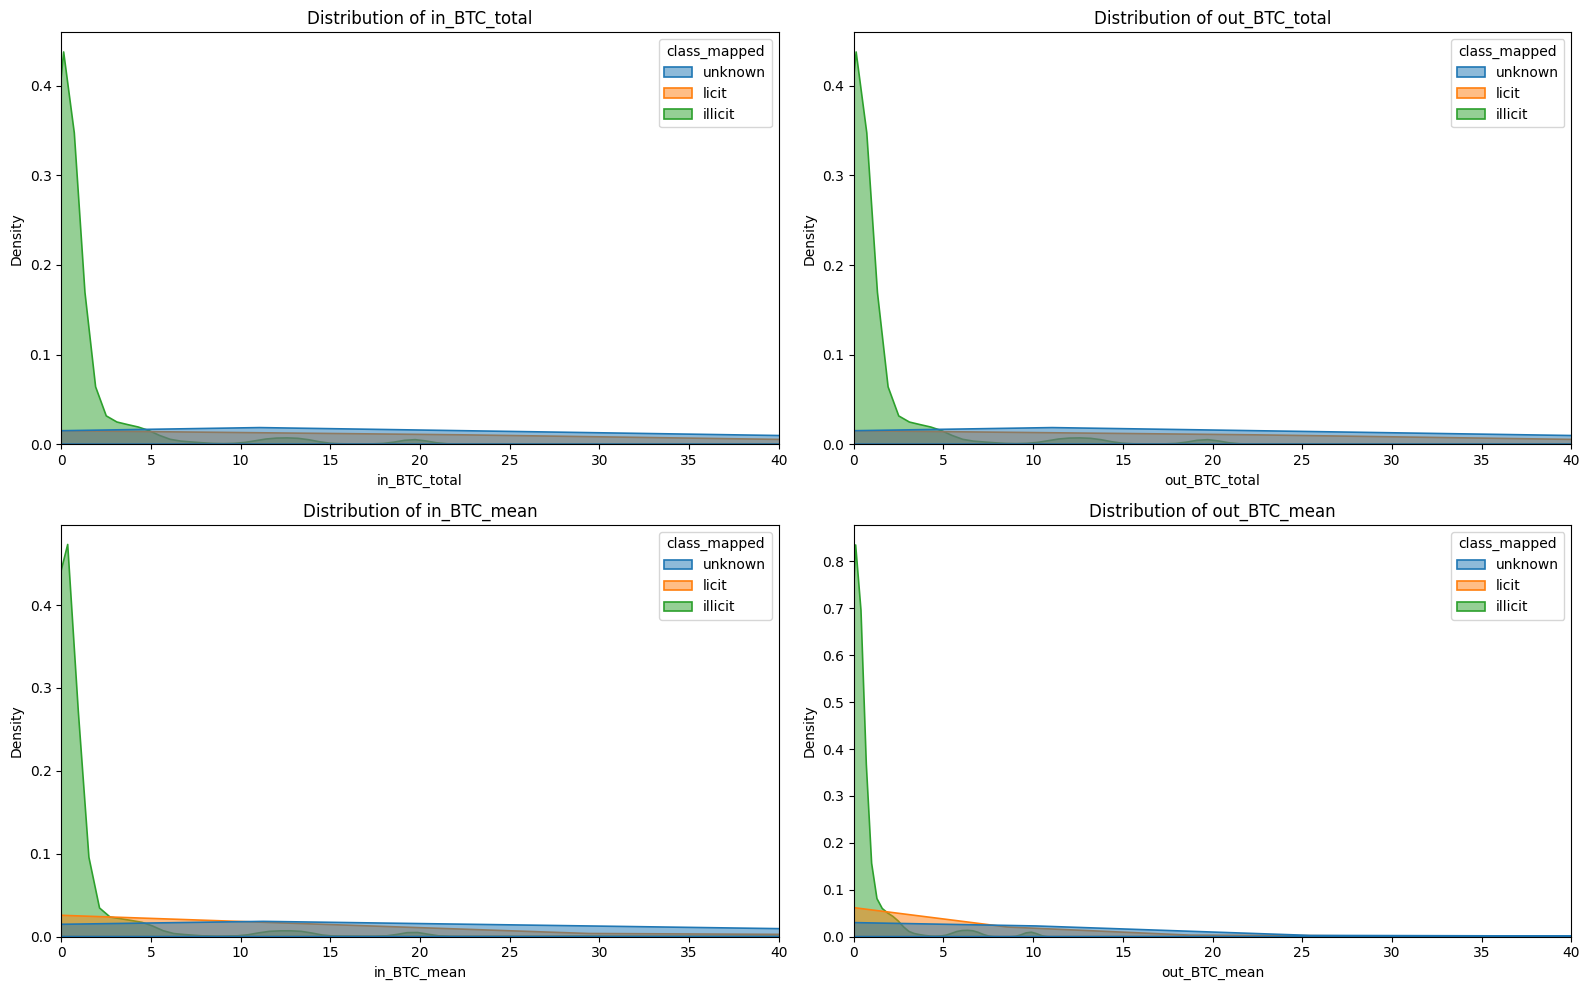

In [10]:
# Feature Distribution EDA (transaction-level)
## understand how transaction features differ beteween illicit vs licit, and detect suspicious behaviour patterns

# Focus on main numeric transfer features
btc_features = ["in_BTC_total", "out_BTC_total", "in_BTC_mean", "out_BTC_mean"]

plt.figure(figsize=(16, 10))  # Bigger figure for clarity
for i, feat in enumerate(btc_features, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(
        data=tx_df,
        x=feat,
        hue="class_mapped",
        fill=True,
        common_norm=False,
        alpha=0.5,
        linewidth=1.2
    )
    plt.xlim(0, 40)  # Zoom in on low-value dense area
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel("Density")
plt.tight_layout()
plt.show()


1. `in_BTC_total`: Total BTC received in the transaction
2. `out_BTC_total`: Total BTC sent out in the transaction
3. `in_BTC_mean`: Average value per input
4. `out_BTC_mean`: Average value per output

**Key Observations from the plot above:**
- Illicit transactions:
  - Most illicit transaction cluster near very small BTC values (suggests smurfing behaviour)
  - Illcit density is spiked near zero
  - Distributions of illicit transactions are right-skewed. Almost no large value transactions for illicit transactions, indicating an avoidance of transacting large detectable flows (expect more small transactions than large transactions)
- Licit transactions:
  - Licit transcations have more spread out distriubtions and longer tails (larger BTC amounts)
  - There is presence of medium to high transaction values, suggesting that licit transactions are operating in normal economic activity as there is a wide range of transaction volumes



## 2.4 Distribution of node degrees

In [11]:
# Sampling for easier analysis
illicit_tx = tx_df[tx_df['class_mapped'] == 'illicit']  # keep all illicit
licit_tx_sample = tx_df[tx_df['class_mapped'] == 'licit'].sample(frac=0.1, random_state=42)  # sample 10% licit

classes_sampled = pd.concat([illicit_tx, licit_tx_sample], ignore_index=True)

tx_id_sampled = classes_sampled['tx_id']

# Filter tx_edges based on the sampled tx_ids
tx_edges_sampled = tx_edges[
    tx_edges['txId1'].isin(tx_id_sampled) | tx_edges['txId2'].isin(tx_id_sampled)
]

# Filter tx_df features based on the sampled tx_ids
features_sampled = tx_df[tx_df['tx_id'].isin(tx_id_sampled)]

print(f"Sampled Classes:\n{classes_sampled['class_mapped'].value_counts()}\n")
print(f"Sampled Edgelist: {tx_edges_sampled.shape[0]:,}")
print(f"Sampled Features: {features_sampled.shape[0]:,}")

Sampled Classes:
class_mapped
illicit    4545
licit      4202
Name: count, dtype: int64

Sampled Edgelist: 21,207
Sampled Features: 8,747


Number of nodes: 8,747
Number of edges: 21,207


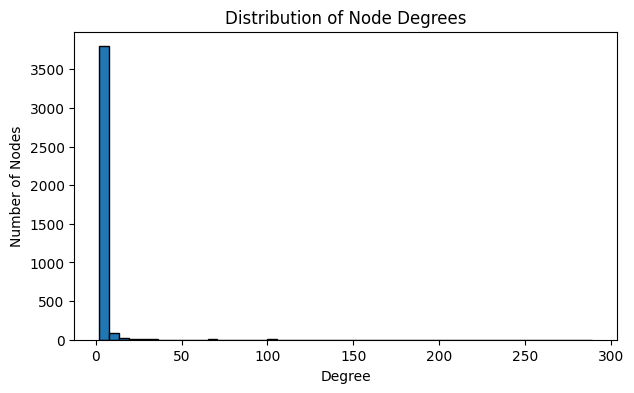

In [12]:
# Number of nodes and edges
num_nodes = features_sampled.shape[0]
num_edges = tx_edges_sampled.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

# Distribution of node degrees
plt.figure(figsize=(7, 4))

node_degrees = tx_edges_sampled['txId1'].value_counts() + tx_edges_sampled['txId2'].value_counts()
node_degrees.hist(bins=50, edgecolor='black')
plt.title('Distribution of Node Degrees')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(False)
plt.show()

The node degree distribution is highly right-skewed, indicating that most transactions are sparsely connected while a small number of high-degree hubs exist. This suggests a scale-free structure in the transaction network. Such hubs are likely to play significant roles in transaction routing and may warrant deeper investigation for potential money laundering activity.

In [13]:
# Create graph from the edgelist
G = nx.from_pandas_edgelist(tx_edges_sampled, 'txId1', 'txId2')

# Attach labels from features_sampled
label_map = dict(zip(features_sampled['tx_id'], features_sampled['class_mapped']))
nx.set_node_attributes(G, label_map, 'class')

Number of connected components: 3882
Giant component - Number of nodes: 473
Giant component - Number of edges: 478


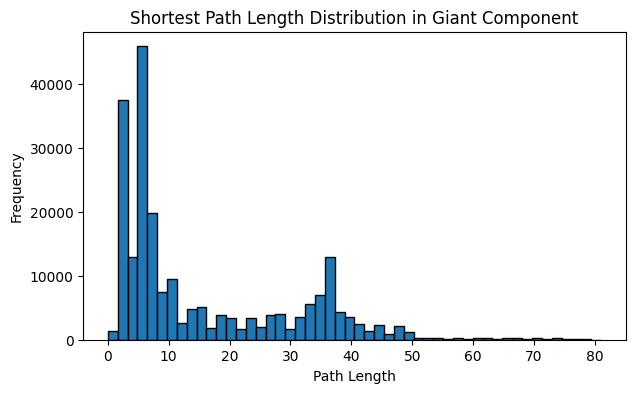

In [14]:
# Connected components
num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")

# Giant component analysis
giant_component = max(nx.connected_components(G), key=len)
G_giant = G.subgraph(giant_component)

print(f"Giant component - Number of nodes: {G_giant.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_giant.number_of_edges():,}")

# Shortest paths length distribution in the giant component
path_lengths = dict(nx.shortest_path_length(G_giant))
path_lengths_values = [length for target_lengths in path_lengths.values() for length in target_lengths.values()]

plt.figure(figsize=(7, 4))
plt.hist(path_lengths_values, bins=50, edgecolor='black')
plt.title('Shortest Path Length Distribution in Giant Component')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.show()

This graph shows the distribution of shortest path lengths between all reachable pairs of nodes inside the giant component of the sampled Bitcoin transaction graph.

**Graph Observations:**
- Most path lengths are short (3 to 10 hops), suggesting local clusters of transactions.
- There is a long tail up to about 80 hops, showing that some transactions are linked through long chains, which are common in fraud.

## 2.5 Centrality on sampled dataset
Degree centrality, betweenness centrality, and closeness centrality.

Top 20 nodes by degree centrality
         Node  Degree Centrality
0   355110272           0.324153
1   355174807           0.144068
2   289827365           0.063559
3   214198067           0.029661
4   355003671           0.027542
5   241477156           0.019068
6   355004415           0.012712
7    16827115           0.010593
8   286791108           0.010593
9   355110526           0.010593
10  355108863           0.008475
11  355004559           0.006356
12  355006712           0.006356
13  355006723           0.006356
14  355006877           0.006356
15  355111463           0.006356
16  355007070           0.006356
17  355095354           0.006356
18  355158933           0.006356
19  355126263           0.006356


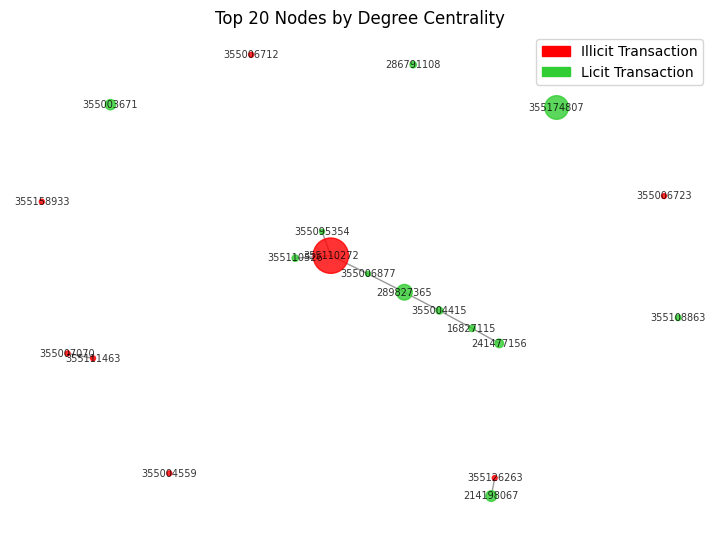

In [15]:
# Degree centrality
degree_centrality = nx.degree_centrality(G_giant)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
df_top_degree_centrality = pd.DataFrame(top_degree_centrality, columns=['Node', 'Degree Centrality'])

print("Top 20 nodes by degree centrality")
print("==================================")
print(df_top_degree_centrality)

# Get subgraph containing only those nodes
top_nodes = df_top_degree_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes)

# Color nodes by class: illicit = red, licit = limegreen
color_map = ['red' if subgraph.nodes[node].get('class') == 'illicit' else 'limegreen'
             for node in subgraph.nodes()]

# Node size based on degree centrality
node_sizes = [degree_centrality[node] * 2000 for node in subgraph.nodes()]

# Plot
plt.figure(figsize=(7,5))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_size=node_sizes,
        node_color=color_map, edge_color='gray', alpha=0.8, font_size=7)

# Legend
red_patch = mpatches.Patch(color='red', label='Illicit Transaction')
limegreen_patch = mpatches.Patch(color='limegreen', label='Licit Transaction')
plt.legend(handles=[red_patch, limegreen_patch], loc='best')

plt.title('Top 20 Nodes by Degree Centrality')
plt.axis('off')
plt.show()

*Degree centrality* measures how many direct connections a node has. Higher degree centrality means that there are more connections, indicating that it is more important or influential.

**Insights:**\
The top 20 nodes by degree centrality include both licit and illicit transactions, but illicit nodes do show noticeable centrality despite being fewer. Their presence among the most connected nodes suggests they play influential roles in the network, potentially acting as transaction routing centers or mixing points often used in laundering strategies.

Top 20 nodes by betweenness centrality:
         Node  Betweenness Centrality
0   289827365                0.618085
1   355110272                0.581958
2   355174807                0.359721
3   355006381                0.307928
4   355006723                0.262779
5   170923175                0.234913
6   164627899                0.233892
7   286791108                0.232651
8   355128655                0.231809
9   355128653                0.228688
10  130186470                0.225548
11  355009659                0.223546
12   17280710                0.222390
13  198981058                0.219214
14  355998296                0.216021
15  355998291                0.212809
16  355009662                0.210074
17  355617472                0.209579
18  309189403                0.206332
19   91806025                0.203066


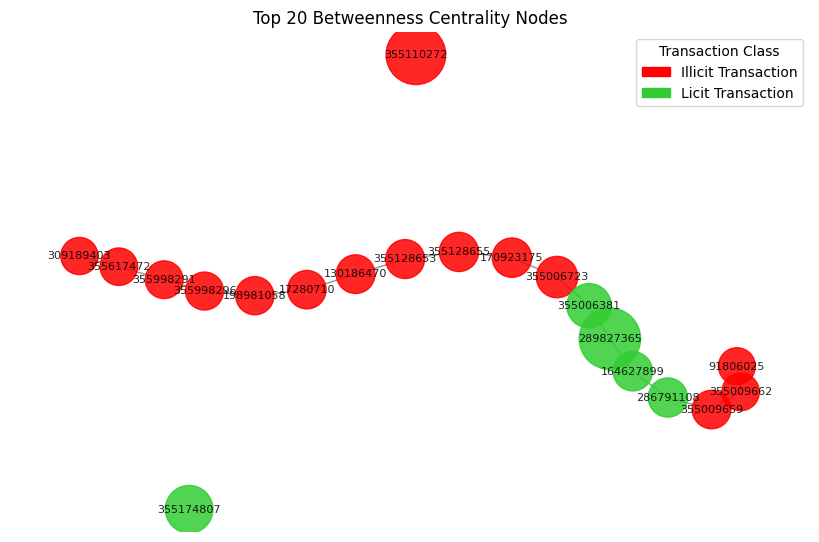

In [16]:
# Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G_giant, normalized=True)

# Get Top 20 nodes
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
df_top_betweenness = pd.DataFrame(top_betweenness, columns=['Node', 'Betweenness Centrality'])

print("Top 20 nodes by betweenness centrality:")
print("=======================================")
print(df_top_betweenness)

# Subgraph of top 20 nodes
top_nodes = df_top_betweenness['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes)

# Node color by fraud class
color_map = [
    'red' if subgraph.nodes[node].get('class') == 'illicit' else 'limegreen'
    for node in subgraph.nodes()
]

# Node size proportional to betweenness
node_sizes = [betweenness_centrality[node] * 3000 + 100 for node in subgraph.nodes()]

# Plot graph
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos,
        node_color=color_map,
        node_size=node_sizes,
        edge_color='gray',
        with_labels=True,
        alpha=0.85,
        font_size = 8)

# Legend
red_patch = mpatches.Patch(color='red', label='Illicit Transaction')
limegreen_patch = mpatches.Patch(color='limegreen', label='Licit Transaction')
plt.legend(handles=[red_patch, limegreen_patch], title="Transaction Class")

plt.title('Top 20 Betweenness Centrality Nodes')
plt.axis('off')
plt.show()

*Betweenness centrality* measures how often a node appears on the shortest paths between other nodes in a network. The size of the node represents their centrality score, larger nodes indicate a higher influence in the money flow.

**Insights:**\
From the plot, it is observed that majority of the top betweenness centrality nodes are illicit. This indicates that illicit transactions are typically not isolate, and instead serve as bridges in fraudulent chains to help mask the origins of funds. Additionally, licit transactions are observed to be central, indicating that they might be transition points for laundering funds into or out of the legitimate economy.

Top 20 nodes by closeness centrality:
         Node  Closeness Centrality
0   289827365              0.111007
1   355110272              0.109057
2   355006877              0.107689
3   355006827              0.107591
4   355005777              0.104217
5   355006381              0.103782
6   164627899              0.102787
7   355092717              0.102497
8   355004415              0.101006
9    14887053              0.099936
10  355004638              0.099936
11  355006942              0.099936
12  355006978              0.099936
13  355006982              0.099936
14  355009082              0.099936
15  355007042              0.099936
16  355009102              0.099936
17  355007127              0.099936
18  176599737              0.099936
19  355007249              0.099936


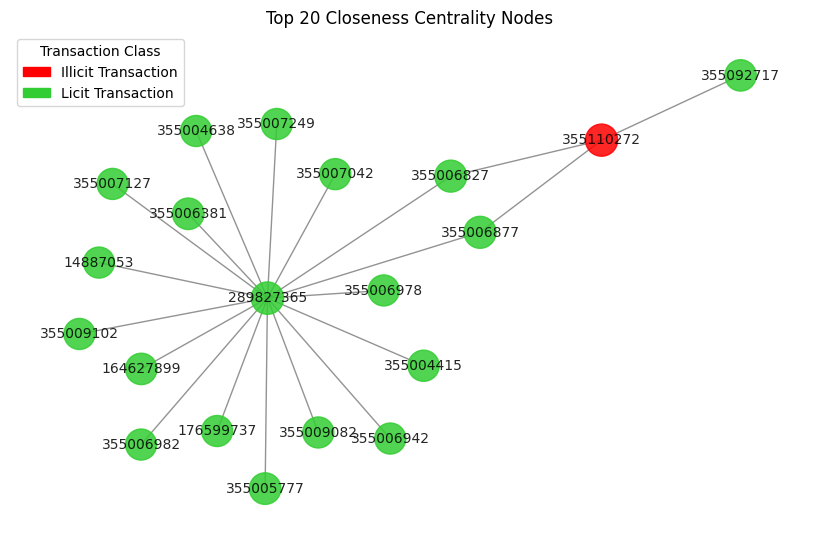

In [17]:
# Closeness Centrality
closeness_centrality = nx.closeness_centrality(G_giant)
top_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:20]
df_top_closeness_centrality = pd.DataFrame(top_closeness_centrality, columns=['Node', 'Closeness Centrality'])

print("Top 20 nodes by closeness centrality:")
print("=====================================")
print(df_top_closeness_centrality)

top_nodes_by_closeness = df_top_closeness_centrality['Node'].tolist()
subgraph = G_giant.subgraph(top_nodes_by_closeness)

# --- Node color by fraud class ---
color_map = [
    'red' if subgraph.nodes[node].get('class') == 'illicit' else 'limegreen'
    for node in subgraph.nodes()
]


# --- Node size proportional to closeness ---
vals = [closeness_centrality[n] for n in subgraph.nodes()]
# scale nicely: add a small base so very small values are visible
node_sizes = [100 + 4000 * v for v in vals]

# --- Plot graph ---
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos,
        node_color=color_map,
        node_size=node_sizes,
        edge_color='gray',
        with_labels=True,
        alpha=0.85,
        font_size = 10)

# Legend
red_patch = mpatches.Patch(color='red', label='Illicit Transaction')
limegreen_patch = mpatches.Patch(color='limegreen', label='Licit Transaction')
plt.legend(handles=[red_patch, limegreen_patch], title="Transaction Class")

plt.title('Top 20 Closeness Centrality Nodes')
plt.axis('off')
plt.show()


*Closeness centrality* measures how close a node is to all other nodes in a network. A higher closeness centrality score indicates that a node is more central because it can reach all other nodes in fewer steps, allowing funds to flow to and from it more efficiently.

**Insights:**\
The node with the highest closeness centrality score is licit, indicating that licit transactions are at the center of the transaction network. Furthermore, a star-shaped network is formed by the licit nodes, showing that many nodes are directly connected. The illicit transaction has a medium closeness centrality score, and it sits on a branch of the graph. This indicates that it is close enough to the main network to move funds quickly.

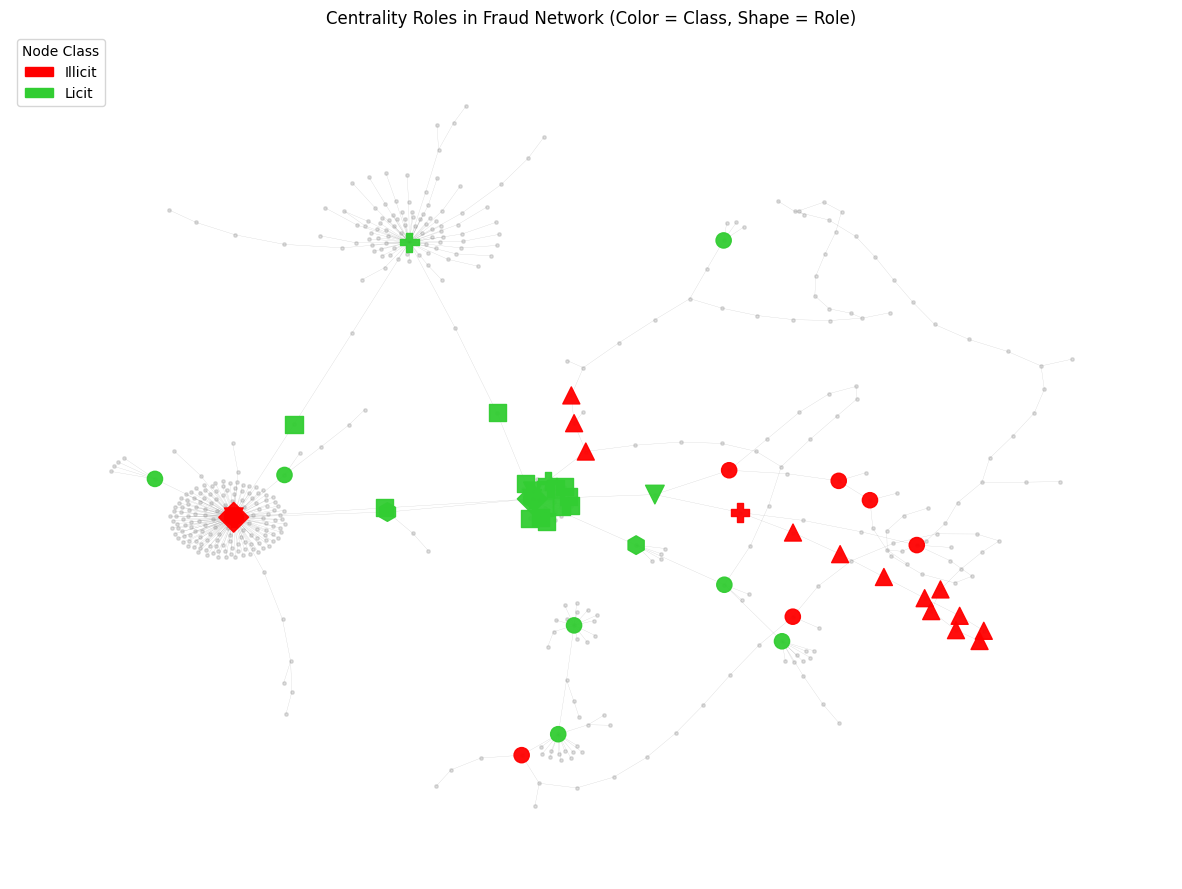

In [18]:
# Graph Visualisation

# Identify nodes that are top in each centrality measure and their combinations
top_nodes_degree = set([node for node, _ in top_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness])
top_nodes_closeness = set([node for node, _ in top_closeness_centrality])

top_nodes_both = top_nodes_degree.intersection(top_nodes_betweenness)
top_nodes_closeness_and_degree = top_nodes_closeness.intersection(top_nodes_degree)
top_nodes_closeness_and_betweenness = top_nodes_closeness.intersection(top_nodes_betweenness)
top_nodes_all_three = top_nodes_closeness.intersection(top_nodes_degree).intersection(top_nodes_betweenness)

# Assign colors and shapes based on centrality measures
# Color nodes by fraud class
node_colors = []
node_shapes = []

for node in G_giant.nodes():
    node_class = G_giant.nodes[node].get('class', 'licit')
    node_colors.append('red' if node_class == 'illicit' else 'limegreen')  # color by fraud class

    # Shapes indicate centrality roles
    if node in top_nodes_all_three:
        node_shapes.append('D')  # Diamond - top in all 3
    elif node in top_nodes_degree:
        node_shapes.append('o')  # Circle - degree hub
    elif node in top_nodes_betweenness:
        node_shapes.append('^')  # Triangle - mixer bridge
    elif node in top_nodes_closeness:
        node_shapes.append('s')  # Square - highly reachable
    else:
        node_shapes.append('o')  # Normal node

# Plot
plt.figure(figsize=(15, 11))
pos = nx.spring_layout(G_giant, seed=42)

# Base graph
nx.draw_networkx_nodes(G_giant, pos, node_color='gray', node_size=6, alpha=0.25)
nx.draw_networkx_edges(G_giant, pos, width=0.2, alpha=0.2)

def node_color(n):
    return 'red' if G_giant.nodes[n].get('class') == 'illicit' else 'limegreen'

# Build disjoint role sets
deg_only = top_nodes_degree - top_nodes_both - top_nodes_closeness_and_degree
bet_only = top_nodes_betweenness - top_nodes_both - top_nodes_closeness_and_betweenness
clo_only = top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness
deg_bet = top_nodes_both
deg_clo = top_nodes_closeness_and_degree
bet_clo = top_nodes_closeness_and_betweenness
all_three = top_nodes_all_three

# Helper to safely draw a category
def draw_cat(nodes, shape, size, label):
    nodes = list(nodes)
    if not nodes:
        return
    colors = [node_color(n) for n in nodes]  # match color list length to nodelist
    nx.draw_networkx_nodes(G_giant, pos,
                           nodelist=nodes,
                           node_color=colors,
                           node_shape=shape,
                           node_size=size,
                           label=label,
                           alpha=0.95)

# Draw categories (shape encodes role; color encodes class)
draw_cat(deg_only, 'o', 120, 'High Degree')
draw_cat(bet_only, '^', 150, 'High Betweenness')
draw_cat(clo_only, 's', 150, 'High Closeness')
draw_cat(deg_bet, 'P', 180, 'Degree & Betweenness')
draw_cat(deg_clo, 'h', 180, 'Degree & Closeness')
draw_cat(bet_clo, 'v', 180, 'Betweenness & Closeness')
draw_cat(all_three, 'D', 230, 'Top in All 3 (Key Hubs)')

# Legend for fraud class
red_patch = mpatches.Patch(color='red', label='Illicit')
limegreen_patch = mpatches.Patch(color='limegreen', label='Licit')
plt.legend(handles=[red_patch, limegreen_patch], loc='upper left', title='Node Class')

plt.title("Centrality Roles in Fraud Network (Color = Class, Shape = Role)")
plt.axis('off')
plt.show()

Description of the plot above:
- Colour indicates the class of the transaction (red indicates illicit, green indicates licit)
- Shape of the point indicates its centrality role (high degree centrality, high betweenness centrality, high closeness centrality, high in both degree and betweenness centralities, high in both degree and closeness centralities, high in both betweenness and close centralities, high in all 3 measures of centralities (key hub))

**Insights:**\
Illicit nodes tend to cluster at network peripheries, appearing in linear chains or isolated components. This suggests that illicit actors are engaged in peel chains and layering, moving funds through multiple hops to hide the source. However, a few of the illicit nodes are in central positions, indicating that they may serve as connectors between illicit and licit regions of the network, and they serve as chokepoints. Overall, majority of the core network points are licit nodes as they are likely to serve as high-centrality hubs and have heavy transactional connectivity.

In [19]:
# Class-based subgraphs
illicit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'illicit']['tx_id']
licit_nodes = classes_sampled[classes_sampled['class_mapped'] == 'licit']['tx_id']

G_illicit = G.subgraph(illicit_nodes)
G_licit = G.subgraph(licit_nodes)

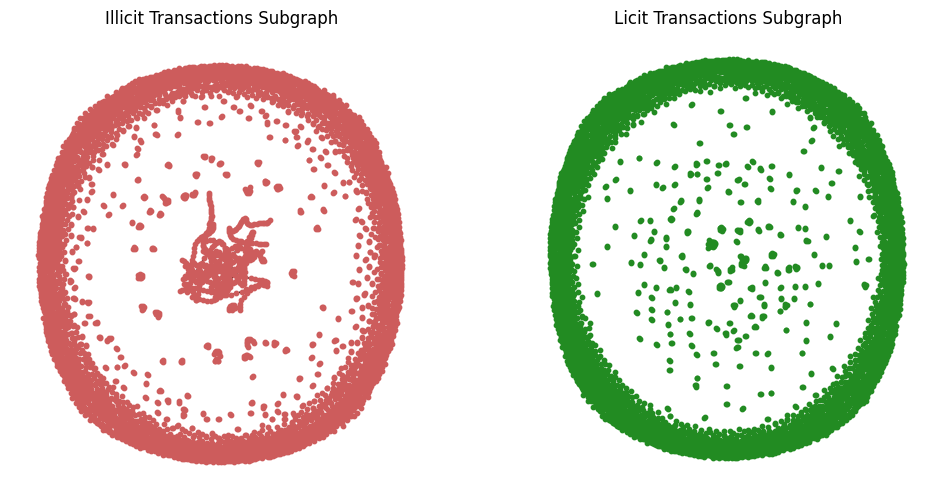

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
nx.draw(G_illicit, with_labels=False, node_size=10, node_color='indianred', edge_color='black')
plt.title('Illicit Transactions Subgraph')

plt.subplot(1, 2, 2)
nx.draw(G_licit, with_labels=False, node_size=10, node_color='forestgreen', edge_color='black')
plt.title('Licit Transactions Subgraph')

plt.show()

**Graph Observations:**


*   Illicit Subgraph (left, red)


    *   The illicit network forms a dense, highly centralised core.
    *   Many transactions are interconnected and feed into or out of a few central nodes, creating a 'spider-web'.
    *   Suggesting that a few key transactions act as intermediaries, either aggregating many smaller incoing transfers or redistributing BTC to multiple addresses.



*   Licit Subgraph (right, green)


    *   The licit network is much more diffuse and uniform.
    *   Transactions are loosely connected, with no single dominant hub.
    *   There are many isolated or lightly connected nodes, which are normal users behaviour where they conduct few transactions, interact with unique counterparties, and do not create deep transaction chains.
    *   Licit activity is distributed and sparse, lacking any coordinated or repetitve transfer pattern.



## 2.6 Temporal EDA

New nodes over the time steps

In [21]:
# Transactions per time step
tx_per_timestep = tx_df.groupby('time_step').size().reset_index(name='count')

# Unique addresses per time step (network growth)
addr_per_timestep = []
for ts in sorted(tx_df['time_step'].unique()):
    ts_txs = tx_df[tx_df['time_step'] == ts]['tx_id']

    # Get addresses involved in this time step
    input_addrs = set(addr_tx_in[addr_tx_in['tx_id'].isin(ts_txs)]['address'].unique())
    output_addrs = set(tx_addr_out[tx_addr_out['tx_id'].isin(ts_txs)]['address'].unique())
    all_ts_addrs = input_addrs | output_addrs

    addr_per_timestep.append({
        'time_step': ts,
        'unique_addresses': len(all_ts_addrs),
        'transactions': len(ts_txs)
    })

addr_growth_df = pd.DataFrame(addr_per_timestep)

In [22]:
# Calculate cumulative unique addresses to find new nodes over time steps
cumulative_addresses = set()
new_nodes_per_step = []

for ts in sorted(tx_df['time_step'].unique()):
    ts_txs = tx_df[tx_df['time_step'] == ts]['tx_id']

    input_addrs = set(addr_tx_in[addr_tx_in['tx_id'].isin(ts_txs)]['address'].unique())
    output_addrs = set(tx_addr_out[tx_addr_out['tx_id'].isin(ts_txs)]['address'].unique())
    current_addrs = input_addrs | output_addrs

    new_addrs = current_addrs - cumulative_addresses
    pct_new = (len(new_addrs) / len(current_addrs) * 100) if len(current_addrs) > 0 else 0

    new_nodes_per_step.append({
        'time_step': ts,
        'new_nodes': len(new_addrs),
        'total_nodes': len(current_addrs),
        'pct_new': pct_new
    })

    cumulative_addresses.update(current_addrs)

new_nodes_df = pd.DataFrame(new_nodes_per_step)

print(f"   - Average % of new nodes per time step: {new_nodes_df['pct_new'].mean():.2f}%")
print(f"   - Median % of new nodes per time step: {new_nodes_df['pct_new'].median():.2f}%")
print(f"   - Max % of new nodes in a time step: {new_nodes_df['pct_new'].max():.2f}%")
print("\n   Top 5 time steps by % new nodes:")
print(new_nodes_df.nlargest(5, 'pct_new')[['time_step', 'new_nodes', 'total_nodes', 'pct_new']])

   - Average % of new nodes per time step: 88.80%
   - Median % of new nodes per time step: 89.90%
   - Max % of new nodes in a time step: 100.00%

   Top 5 time steps by % new nodes:
    time_step  new_nodes  total_nodes     pct_new
0           1      34853        34853  100.000000
1           2      24383        24847   98.132571
40         41      21392        22253   96.130859
3           4      20197        21030   96.038992
2           3      19274        20137   95.714357


The extremely high percentage of new nodes over the time steps indicates that the transaction network is highly dynamic and new transactions are constantly enterring the network. Thus, inductive GNNs might be more useful in this case and we can consider using GraphSAGE for fraud prediction as it aggregates from neighbourhoods and can generalize to new nodes that are not seen during training.

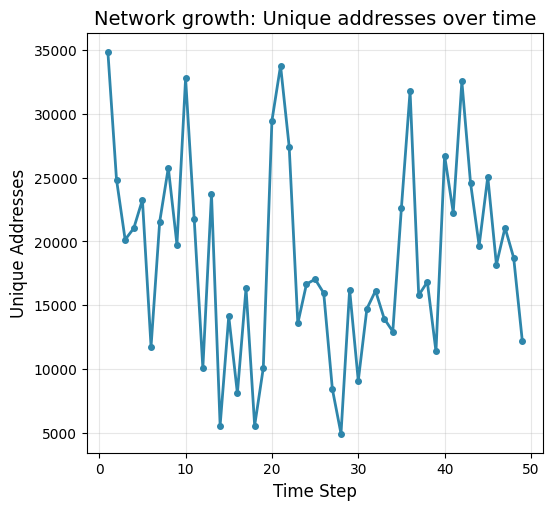

In [23]:
# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# Plot 1: Network Growth Over Time
ax1 = plt.subplot(2, 3, 1)
ax1.plot(addr_growth_df['time_step'], addr_growth_df['unique_addresses'],
         marker='o', linewidth=2, markersize=4, color='#2E86AB')
ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Unique Addresses', fontsize=12)
ax1.set_title('Network growth: Unique addresses over time', fontsize=14)
ax1.grid(True, alpha=0.3)

Fraud pattern evolution over the time step

In [24]:
# Compare illicit vs licit patterns over time periods
def analyze_class_patterns_over_time(df, feature, class_col='class_mapped'):

    time_steps = sorted(df['time_step'].unique())
    n_steps = len(time_steps)

    early_steps = time_steps[:n_steps//3]
    late_steps = time_steps[2*n_steps//3:]

    # Early period
    early_illicit = df[(df['time_step'].isin(early_steps)) &
                       (df[class_col] == 'illicit')][feature].dropna()
    early_licit = df[(df['time_step'].isin(early_steps)) &
                     (df[class_col] == 'licit')][feature].dropna()

    # Late period
    late_illicit = df[(df['time_step'].isin(late_steps)) &
                      (df[class_col] == 'illicit')][feature].dropna()
    late_licit = df[(df['time_step'].isin(late_steps)) &
                    (df[class_col] == 'licit')][feature].dropna()

    if len(early_illicit) < 10 or len(late_illicit) < 10:
        return None

    # Calculate separation between classes in early vs late
    early_separation = abs(early_illicit.mean() - early_licit.mean()) / early_licit.std() if early_licit.std() > 0 else 0
    late_separation = abs(late_illicit.mean() - late_licit.mean()) / late_licit.std() if late_licit.std() > 0 else 0

    # How much illicit pattern changed
    illicit_drift = ks_2samp(early_illicit, late_illicit)[0]

    return {
        'feature': feature,
        'early_separation': early_separation,
        'late_separation': late_separation,
        'separation_change': late_separation - early_separation,
        'illicit_pattern_drift': illicit_drift
    }

In [25]:
non_feature_cols = ['tx_id', 'time_step', 'in_BTC_mean', 'in_BTC_median', 'in_BTC_total', 'out_BTC_min', 'out_BTC_max', 'out_BTC_mean',
                    'out_BTC_median', 'out_BTC_total', 'class', 'class_mapped', 'in_txs_degree', 'out_txs_degree', 'total_BTC', 'fees', 'size',
                    'num_input_addresses', 'num_output_addresses', 'in_BTC_min', 'in_BTC_max']
feature_cols = [c for c in tx_df.columns if c not in non_feature_cols and tx_df[c].dtype in [float, int]]

fraud_pattern_changes = []
for feat in feature_cols[:15]:
    try:
        result = analyze_class_patterns_over_time(tx_df, feat)
        if result:
            fraud_pattern_changes.append(result)
    except:
        continue

fraud_df = pd.DataFrame(fraud_pattern_changes)
fraud_df = fraud_df.sort_values('illicit_pattern_drift', ascending=False)

print("\n Features where fraud patterns changes the most:")
print(fraud_df.head(10))

evolving_fraud = fraud_df[fraud_df['illicit_pattern_drift'] > 0.1]
print(f" {len(evolving_fraud)} features show evolving fraud patterns (drift > 0.1)")


 Features where fraud patterns changes the most:
             feature  early_separation  late_separation  separation_change  \
2    Local_feature_3          0.637373         0.342331          -0.295042   
1    Local_feature_2          0.083702         0.150438           0.066737   
10  Local_feature_11          0.193006         0.169771          -0.023235   
7    Local_feature_8          0.168562         0.163761          -0.004801   
8    Local_feature_9          0.190351         0.174763          -0.015588   
0    Local_feature_1          0.193457         0.180354          -0.013103   
5    Local_feature_6          0.170429         0.045382          -0.125047   
3    Local_feature_4          0.170540         0.056310          -0.114230   
9   Local_feature_10          0.130205         0.060856          -0.069349   
4    Local_feature_5          0.045907         0.068382           0.022474   

    illicit_pattern_drift  
2                0.967875  
1                0.924438  
10     

This shows that feature behaviour for 11 features show fraud patterns that evolves across time steps, which highlights that an inductive model may be more promising in identifying fraud.

# 3. Our hypotheses about the datasets, and further EDA to test them
1. Illicit transactions (nodes) are more likely to form tightly connected clusters. Results in high homophily scores as fradulent transactions are likely to be interconnected.

2. Illicit transactions (nodes) are more likely to be central nodes in transaction flows, and have higher centrality scores as they are part of laundering chains.\
Illicit transactions tend to have a high betweeness centrality, suggesting that they lie on many paths and acts as intermediate nodes in longer transaction flows to launder funds. \
Extremely high or extremely low ratios of in-degree and out-degree can indicate suspicious transactional behaviour. On the other hand, ratio of approximately 1 may signify a peel chain.

3. Illicit wallets are expected to be part of a longer path length. The longer the path length of a node, the higher probability for it to be illicit because criminals move funds through multiple wallets to obscure the origin, making it harder to track the source.
    - Path length: Chain of transactions from a start
    - Start of a path: Transaction with no incoming edges (in-deg)
    - End of a path: Transaction with no outgoing edges (out-deg)

## 3.1 Homophily score: Transaction network level

In [26]:
# tx_edges has 'txId1' and 'txId2' transaction IDs
edges = tx_edges.copy()

# Merge source labels
edges = edges.merge(
    tx_df[['tx_id', 'class']],
    left_on='txId1', right_on='tx_id', how='left'
).rename(columns={'class':'class_src'}).drop(columns=['tx_id'])

# Merge target labels
edges = edges.merge(
    tx_df[['tx_id', 'class']],
    left_on='txId2', right_on='tx_id', how='left'
).rename(columns={'class':'class_dst'}).drop(columns=['tx_id'])

In [27]:
# Filter out edges with unknown class (3)
edges = edges[(edges['class_src'] != 3.0) & (edges['class_dst'] != 3.0)]

same_class_edges = (edges['class_src'] == edges['class_dst']).sum()
total_edges = len(edges)

homophily_score = same_class_edges / total_edges
print(f"Transaction-level homophily: {homophily_score:.4f}")

Transaction-level homophily: 0.9537


At the transaction-level network, there is a high homophily score of  0.9537, highlighting that most edges connect to transaction nodes of the same class, and hence illicit transactions tend to interact with each other, indicating possible fraud clusters of fraud rings.

## 3.3 Path length

Prepare Tx-Tx graph for analysis in a directed graph

In [28]:
G_dir = nx.from_pandas_edgelist(tx_edges, 'txId1', 'txId2', create_using=nx.DiGraph())

# Identify start/end of transaction chains
start_txs = [n for n in G_dir.nodes() if G_dir.in_degree(n) == 0]
end_txs = [n for n in G_dir.nodes() if G_dir.out_degree(n) == 0]

print(f"Start transactions: {len(start_txs)}")
print(f"End transactions: {len(end_txs)}")

Start transactions: 55322
End transactions: 37424


In [29]:
# Compute path lengths
# path length is from start nodes to all reachable nodes

tx_path_length = {}

for start in start_txs:
    lengths = nx.single_source_shortest_path_length(G_dir, start)
    for tx, length in lengths.items():
        # Keep the longest path if multiple start nodes reach the same tx
        if tx not in tx_path_length or length > tx_path_length[tx]:
            tx_path_length[tx] = length

df_path_length = pd.DataFrame({
    'tx_id': list(tx_path_length.keys()),
    'path_length': list(tx_path_length.values())
})

In [30]:
def node_label(tx):
    if G_dir.in_degree(tx) == 0:
        return 'start'
    elif G_dir.out_degree(tx) == 0:
        return 'end'
    else:
        return 'intermediate'

df_path_length['node_type'] = df_path_length['tx_id'].apply(node_label)

In [31]:
# Merge with class labels so we can identify
df_path_length = df_path_length.merge(tx_df[['tx_id', 'class_mapped']], on='tx_id', how='left')

In [32]:
df_path_length.head()

,tx_id,path_length,node_type,class_mapped
0,230333930,0,start,unknown
1,230595899,3,intermediate,unknown
2,232015639,1,intermediate,unknown
3,232675746,4,intermediate,unknown
4,230440000,21,intermediate,unknown


In [33]:
df_path_length['path_length'].describe()

count    203769.000000
mean         21.183492
std          80.140213
min           0.000000
25%           0.000000
50%           2.000000
75%           8.000000
max        1248.000000
Name: path_length, dtype: float64

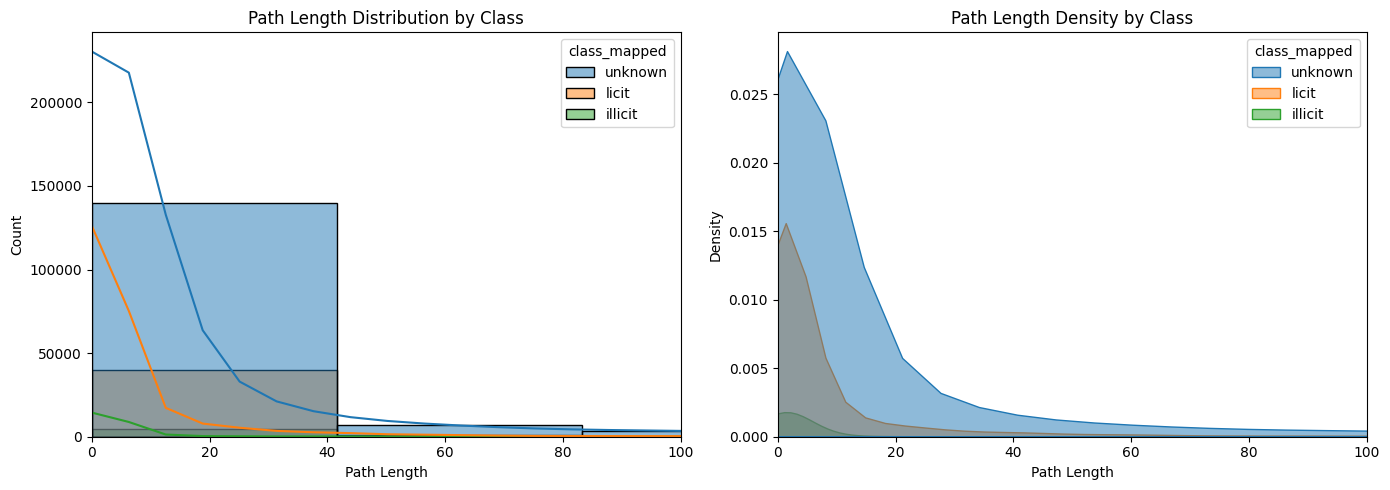

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
sns.histplot(
    data=df_path_length,
    x='path_length',
    hue='class_mapped',
    bins=30,
    kde=True,
    ax=axes[0])
axes[0].set_title('Path Length Distribution by Class')
axes[0].set_xlabel('Path Length')
axes[0].set_xlim(0, 100)  # limit the x-axis for better visibility, since 75th percentile is 8

# KDE plot
sns.kdeplot(
    data=df_path_length,
    x='path_length',
    hue='class_mapped',
    fill=True,
    alpha=0.5,
    ax=axes[1]
)
axes[1].set_title('Path Length Density by Class')
axes[1].set_xlabel('Path Length')
axes[1].set_xlim(0, 100)

plt.tight_layout()
plt.show()


The dataset does not support the hypothesis that nodes with a longer path length are more likely to be illicit, as the graph shows that there is a consistent higher proportion of licit nodes across that are part of longer path lengths.

# 4. Feature engineering on Transaction-level datasets

## 4.1 Feature 1 : Fan-in and Fan-out
**Fan-in** is the number of unique input addressess sending funds to a transaction.

**Fan-out** is the number of unique output addresses sending funds to a transaction.

Both fan-in and fan-out capture the structural complexity and intent behind a transaction. They reveal the direction of fund movement and help to differentiate normal user activity from illicit laundering patterns, especially smurfing and peel-chain behaviours.


*   **High Fan-in**: Many inputs merge into one transaction.

*   **High Fan-out**: One transaction splits into many outputs. This may indicate smurfing behaviour - distributing funds into many small wallets to obscure the money trail.

*   **Low Fan-in and High Fan-out**: Typical smurfing pattern where one wallet acts as a distribution hub.

*   **High Fan-in and Low Fan-out**: Centralising pattern, often for the consolidation of funds.





In [35]:
# Number of outputs (fan-out)
fan_out = tx_addr_out.groupby('tx_id')['address'].nunique().reset_index()
fan_out.columns = ['tx_id', 'fan_out']

# Number of inputs (fan-in)
fan_in = addr_tx_in.groupby('tx_id')['address'].nunique().reset_index()
fan_in.columns = ['tx_id', 'fan_in']

# Merge into tx_df
tx_df = tx_df.merge(fan_out, on='tx_id', how='left')
tx_df = tx_df.merge(fan_in, on='tx_id', how='left')

# Fill missing
tx_df[['fan_in', 'fan_out']] = tx_df[['fan_in', 'fan_out']].fillna(0).astype(int)

tx_df.head()

,tx_id,time_step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class,class_mapped,fan_out,fan_in
0,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.534072,1.668990e-01,0.367074,0.266986,0.266986,0.533972,3,unknown,2,1
1,11108,1,-0.137586,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.127429,...,5.611878,5.861940e-01,5.025584,2.805889,2.805889,5.611778,3,unknown,2,1
2,51816,1,-0.170103,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160699,...,0.456608,2.279902e-01,0.228518,0.228254,0.228254,0.456508,3,unknown,2,1
3,68869,1,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,...,9.308900,1.229000e+00,8.079800,4.654400,4.654400,9.308800,2,licit,2,1
4,89273,1,5.202107,-0.210553,-1.756361,-0.121970,260.090707,-0.113002,-0.061584,5.335864,...,852.164680,1.300000e-07,41.264036,0.065016,0.000441,852.164680,2,licit,13107,1


## 4.2 Feature 2 : Many outputs flag

*   The `many_outputs_flag` is a binary indicator (0 or 1) that signals whether a transaction sends funds to many different recipient addresses.

*   It is derived from the **fan-out** metric, which counts the number of unique output addresses associated with each transaction.

*   Based on the dataset statistics below, trasactions with three or more output addresses are flagged as `1` (many outputs), while the rest are `0`. This is because in most normal transactions, a BTC transaction typically has 1-2 outputs, so having three or more outputs may reflect smurfing behaviour. 75th perentile is 2 outputs, and around 90th percentile is 3 outputs, thus we take 3 as the threshold.

In [36]:
print("Fan out statistics:")
print(tx_df['fan_out'].describe())

print("\nFan out value counts:")
print(tx_df['fan_out'].value_counts().sort_index())

print("\n90th percentile of fan out:")
print(tx_df['fan_out'].quantile(0.9))

Fan out statistics:
count    203769.000000
mean          4.108201
std          49.338217
min           0.000000
25%           2.000000
50%           2.000000
75%           2.000000
max       13107.000000
Name: fan_out, dtype: float64

Fan out value counts:
fan_out
0           965
1         19128
2        162675
3          5104
4          2092
          ...  
4902          1
4906          1
4912          1
5341          1
13107         1
Name: count, Length: 276, dtype: int64

90th percentile of fan out:
3.0


In [37]:
tx_df['many_outputs_flag'] = (tx_df['fan_out'] >= 3).astype(int)

## 4.3 Feature 3 : Small outputs flag

*   The `small_outputs_flag` is a binary indicator (0 or 1) that identifies transactions whose average output value is unusually small compared to the overall distribution of transaction amounts in the dataset.

*   It is computed with a data-driven threshold (the 20th percentile of `out_BTC_mean` among positive-valued transactions)

*   In this case, trasactions whose mean output amount falls below the threhold are flagged as `1` (unusually small outputs), while the rest are `0`. In smurfing, large sums are 'structured' into smaller pieces that fall below detection threshold used by compliane and monitoring systems. By examining the average value per transaction output, this feature higlights transactions that may be sending repetitive small-amount payments or distributing small sums to many addresses.

*   To determine the bottom tail of transactions where outputs are much smaller than typical values, we use an elbow plot for visualization




In [38]:
vals = tx_df.loc[tx_df['out_BTC_mean'] > 0, 'out_BTC_mean']
vals.describe(percentiles=[.01, .05, .10, .25, .30, .40, .50, .75, .90, .95, .99])

count    202804.000000
mean         11.852566
std          67.111277
min           0.000006
1%            0.000633
5%            0.003975
10%           0.008321
25%           0.035485
30%           0.054484
40%           0.126355
50%           0.280447
75%           2.618991
90%          18.855194
95%          55.319283
99%         203.609470
max        2998.404230
Name: out_BTC_mean, dtype: float64

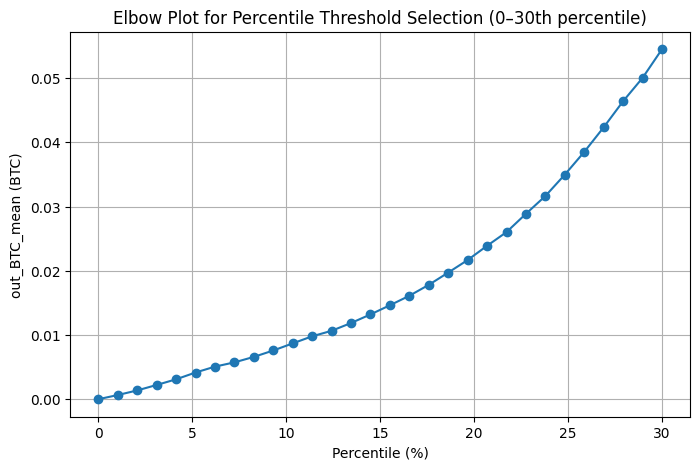

In [39]:
# Only consider positive values
vals = tx_df.loc[tx_df['out_BTC_mean'] > 0, 'out_BTC_mean']

# Focus on only 0% to 30%
percentiles = np.linspace(0, 0.3, 30)
thresholds = [vals.quantile(p) for p in percentiles]

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(percentiles * 100, thresholds, marker='o')
plt.xlabel('Percentile (%)')
plt.ylabel('out_BTC_mean (BTC)')
plt.title('Elbow Plot for Percentile Threshold Selection (0–30th percentile)')
plt.grid(True)
plt.show()

In [40]:
# Detect the elbow (knee)
knee = KneeLocator(percentiles, thresholds, curve='convex', direction='increasing')
elbow_percentile = knee.knee
elbow_value = vals.quantile(elbow_percentile)

print(f"Elbow detected at percentile ≈ {elbow_percentile*100:.1f}%")
print(f"Corresponding out_BTC_mean ≈ {elbow_value:.3f} BTC")

Elbow detected at percentile ≈ 17.6%
Corresponding out_BTC_mean ≈ 0.018 BTC


In [41]:
## `small_outputs_flag': small repetitive amounts -> set threshold around 0.2
small_threshold = tx_df[tx_df['out_BTC_mean'] > 0]['out_BTC_mean'].quantile(0.20)
tx_df['small_outputs_flag'] = (tx_df['out_BTC_mean'] <= small_threshold).astype(int)

## 4.4 Feature 4 : Equal split flag

*   The `equal_split_flag` is a binary feature (0 or 1) that detects whether a transaction's output amounts are roughly equal in size.

*   It is computed using the `out_range_ratio` which is the ratio between the range of output values (max - min) and the mean output value.

*   A transaction is flagged `1` (outputs are nearly equal) when its output range ratio is less than 0.1, meaning all its outputs are within 10% of each other - a sign that the funds are somewhat being evenly split.

*   This feature is used as it identifies structured or uniform fund distribution, where a transaction divides its outputs into similar-sized chunks. Such behaviour is often observed in smurfing or peel-chain laundering, where fraudsters try to make multiple outputs appear consistent and unremarkable.







In [42]:
# 5. Equal split indicator
## Detect when outputs are split into similar size chunks
tx_df['out_range_ratio'] = (
    (tx_df['out_BTC_max'] - tx_df['out_BTC_min']) /
    (tx_df['out_BTC_mean'] + 1e-9)
)

In [43]:
print(tx_df['out_range_ratio'].quantile([0.01, 0.05, 0.10, 0.20, 0.30]))

0.01    0.000000
0.05    0.000000
0.10    0.022868
0.20    0.717045
0.30    1.287617
Name: out_range_ratio, dtype: float64


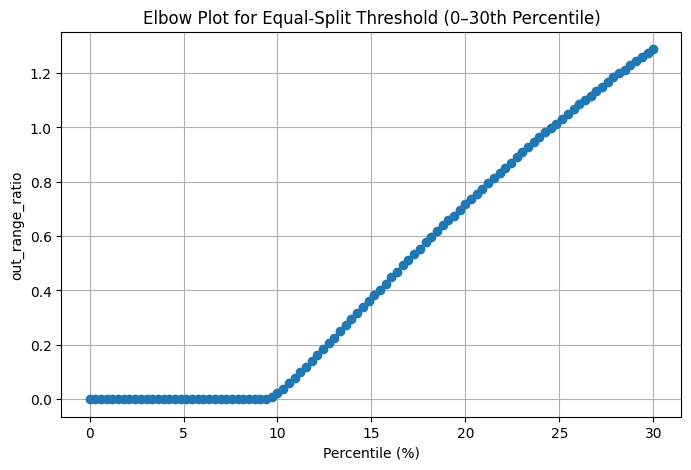

In [44]:
# Only consider out_range_ratio values
vals = tx_df['out_range_ratio'].dropna()

# Generate percentiles 0% to 30%
percentiles = np.linspace(0, 0.3, 100)
thresholds = [vals.quantile(p) for p in percentiles]

plt.figure(figsize=(8,5))
plt.plot(percentiles*100, thresholds, marker='o')
plt.xlabel('Percentile (%)')
plt.ylabel('out_range_ratio')
plt.title('Elbow Plot for Equal-Split Threshold (0–30th Percentile)')
plt.grid(True)

In [45]:
# Detect elbow (knee)
knee = KneeLocator(percentiles, thresholds, curve='convex', direction='increasing')
elbow_percentile = knee.knee
elbow_value = vals.quantile(elbow_percentile)

print(f"Elbow detected at percentile ≈ {elbow_percentile*100:.1f}%")
print(f"Corresponding out_range_ratio ≈ {elbow_value:.3f}")

Elbow detected at percentile ≈ 9.7%
Corresponding out_range_ratio ≈ 0.008


In [46]:
tx_df['equal_split_flag'] = (tx_df['out_range_ratio'] < 0.1).astype(int)

## 4.5 Feature 5 : 1-in-2-out degree

in_degree == 1 & out_degree == 2 could indicate that the transaction receives an amount of bitcoin from one address, then sends out outputs to 2 address. This highlights peel-chain behaviour as the main output & peeled-off output make up the 2 output address linked to the transaction.

In [48]:
# Identify candidate peel-chain transactions
tx_df['1_in_2_out'] = (
    (tx_df['fan_in'] == 1) &
    (tx_df['fan_out'] == 2)).astype(int)

tx_df.head()

,tx_id,time_step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,out_BTC_total,class,class_mapped,fan_out,fan_in,many_outputs_flag,small_outputs_flag,out_range_ratio,equal_split_flag,1_in_2_out
0,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.533972,3,unknown,2,1,0,0,0.749756,0,1
1,11108,1,-0.137586,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.127429,...,5.611778,3,unknown,2,1,0,0,1.582169,0,1
2,51816,1,-0.170103,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160699,...,0.456508,3,unknown,2,1,0,0,0.002313,1,1
3,68869,1,-0.114267,-0.184668,-1.201369,0.028105,-0.043875,-0.113002,0.547008,-0.161652,...,9.308800,2,licit,2,1,0,0,1.471898,0,1
4,89273,1,5.202107,-0.210553,-1.756361,-0.121970,260.090707,-0.113002,-0.061584,5.335864,...,852.164680,2,licit,13107,1,1,0,634.675103,0,0


# 5. EDA on datasets with engineered features

## 5.1 For fan-in and fan-out behaviours

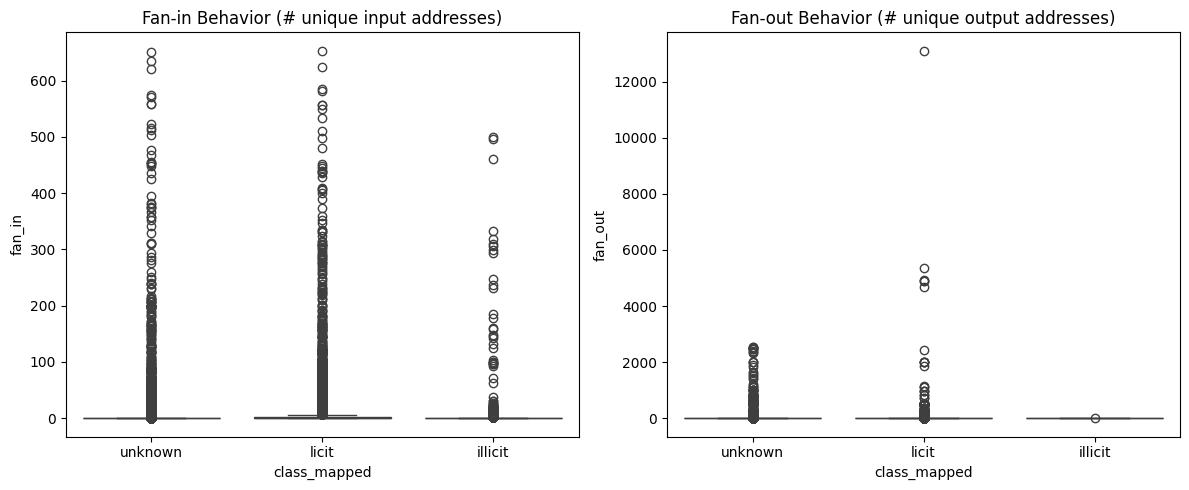

In [49]:
# EDA for smurfing features
# Fan-in and Fan-out behaviours
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(data=tx_df, x="class_mapped", y="fan_in")
plt.title("Fan-in Behavior (# unique input addresses)")

plt.subplot(1,2,2)
sns.boxplot(data=tx_df, x="class_mapped", y="fan_out")
plt.title("Fan-out Behavior (# unique output addresses)")

plt.tight_layout()
plt.show()

**Graph Observations:**
- Both unknown and licit transactions show a wide distribution of fan-in values, including extreme outliers with over 600 unique inputs.
- Illicit transactions, however, generally have fewer inputs, clustering near the lower end of the distribution. This may suggest that these wallets function primarily as intermediate nodes in money-laundering chains, passing along funds rather than aggregating them.
- The majority of transactions have low fan-out values. However, licit transactions have some extreme fan-out outliers, reaching over 10,000 outputs.
- Illicit transations, in contrast, show limited fan-out, typically sending funds to only a few recipients. This indicates that laundering wallets do not engage in large-scale dispesal at once but may perform smaller transfers instead, which is an indication of peel-chain behaviour.

## 5.2 For many outputs flag

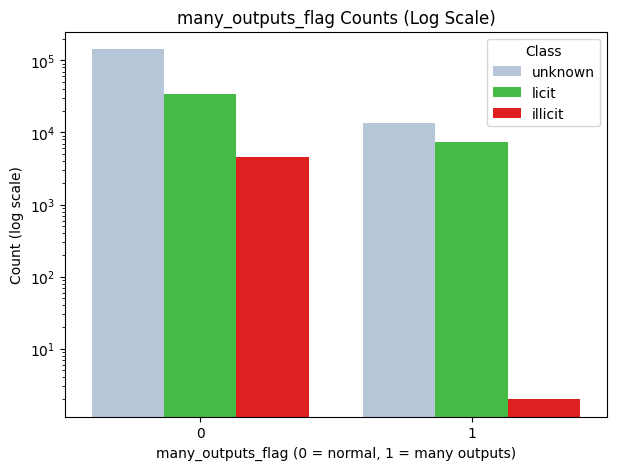

In [50]:
plt.figure(figsize=(7,5))
sns.countplot(data=tx_df, x='many_outputs_flag', hue='class_mapped',
             palette={'illicit':'red', 'licit':'limegreen', 'unknown':'lightsteelblue'})
plt.yscale('log')
plt.title('many_outputs_flag Counts (Log Scale)')
plt.xlabel('many_outputs_flag (0 = normal, 1 = many outputs)')
plt.ylabel('Count (log scale)')
plt.legend(title='Class')
plt.show()

*  `many_outputs_flag = 0`: Normal transaction with few outputs
*  `many_outputs_flag = 1`: Suspicious transactions as there are many output addresses

Graph Observations:
- Most transactions have `many_out_flags = 0`. This means that most transactions do not distribute funds to many addresses, and this is often observed in normal blockchain activity.
- There are more licit transactions with `many_out_flags = 1` than illicit and this may be because the dataset is imbalanced where most transactions in the dataset are unknowns and licit.
- However, although there are much lesser illicit transactions in the dataset, there is still a visible number of illicit transactions with many outputs. This supports the hypothesis that illicit actors split funds to many wallets to avoid traceability, which is also a smurfing tactic.*

## 5.3 For small outputs flag

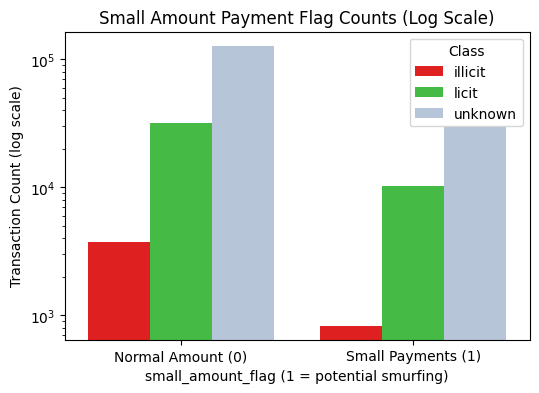

In [51]:
# Keep only licit & illicit for clarity
plt.figure(figsize=(6,4))
sns.countplot(data=tx_df, x='small_outputs_flag', hue='class_mapped',
              hue_order=['illicit', 'licit', 'unknown'],
              palette={'illicit':'red','licit':'limegreen', 'unknown':'lightsteelblue'})
plt.yscale('log')
plt.title('Small Amount Payment Flag Counts (Log Scale)')
plt.xlabel('small_amount_flag (1 = potential smurfing)')
plt.ylabel('Transaction Count (log scale)')
plt.xticks([0,1], ['Normal Amount (0)', 'Small Payments (1)'])
plt.legend(title='Class')
plt.show()


Graph Observations:
- Across all three transaction classes, most transactioins fall under the normal amount category (flag=0). Small amount transactions (flag=1) are relatively rare overall.
- Unknown transactions (blue) dominate in total volume for both normal and small payments, which may be because majority of the transactions in the dataset are unknown.
- Illicit transactions (red) show the smallest count overall, but it is noticeable that there is still a subset of small payment transactions, indicating that there are illicit wallets that engage in smaller, structured transfers, consistent with smurfing patterns.
- Additionally, illicit transactions marked as normal may indicate peel-chain behaviour where moderately sized payments are transferred sequentially across multiple addresses to obscure traceability.

## 5.4 For equal split flag

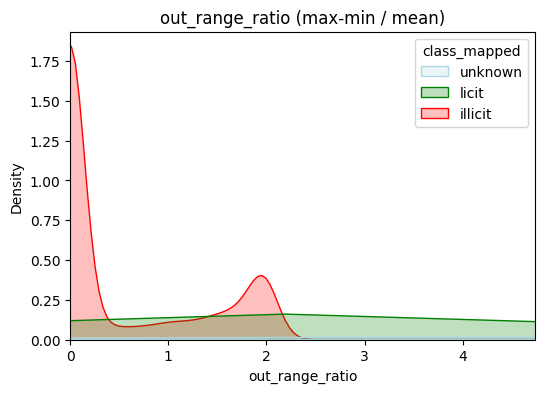

In [52]:
plt.figure(figsize=(6,4))
sns.kdeplot(data=tx_df, x='out_range_ratio', hue='class_mapped',
            palette={'illicit':'red', 'licit':'green', 'unknown':'lightblue'},
            common_norm=False, fill=True)
plt.xlim(0, tx_df['out_range_ratio'].quantile(0.95))
plt.title('out_range_ratio (max-min / mean)')
plt.show()


`out_range_ratio` measures how similar or different the outputs amounts are within a transaction.

If the `out_range_ratio` is close to 0, it means that the output amounts are nearly equal, which could be possible smurfing (money split into equal parts)

If the `out_range_ratio` is high, it suggests that the output amounts vary, which may be a sign of normal transfer activity.

**Graph Observation:**
- Illicit transactions (red) have a strong peak near 0, meaning that many illicit transactions split funds into equal-sized outputs, a classic smurfing pattern.
- There is also a second smaller peak around 2, suggesting that some illicit transactions also split funds unevenly.
- Licit transactions (green) are more spread out and rarely have `out_range_ratio` close to 0, meaning that licit transactions don't usually split money equally.
- Unknown class (blue) lies flat in the graph, making it less meaningful here.

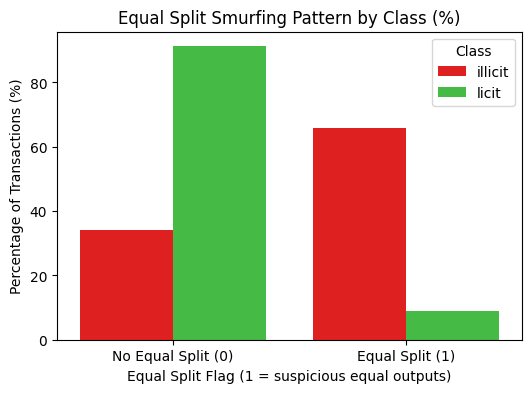


Summary Table: Percentage of Equal Split by Class


equal_split_flag,No Equal Split (0),Equal Split (1)
class_mapped,,
illicit,34.13,65.87
licit,91.21,8.79


In [53]:
# Equal split flag visualisation
# Filter only licit and illicit
filtered = tx_df[tx_df['class_mapped'].isin(['licit', 'illicit'])]

# Calculate percentage per class
equal_split_pct = (
    filtered.groupby(['class_mapped', 'equal_split_flag'])
    .size()
    .rename("count")
    .reset_index()
)
equal_split_pct['percentage'] = (
    equal_split_pct['count'] /
    equal_split_pct.groupby('class_mapped')['count'].transform('sum') * 100
)

# Plot percentage bar chart
plt.figure(figsize=(6,4))
sns.barplot(data=equal_split_pct, x='equal_split_flag', y='percentage', hue='class_mapped',
            palette={'illicit':'red','licit':'limegreen'})

plt.title('Equal Split Smurfing Pattern by Class (%)')
plt.xlabel('Equal Split Flag (1 = suspicious equal outputs)')
plt.ylabel('Percentage of Transactions (%)')
plt.xticks([0,1], ['No Equal Split (0)', 'Equal Split (1)'])
plt.legend(title='Class', loc='upper right')
plt.show()


# Summary
summary_table = equal_split_pct.pivot_table(
    values='percentage',
    index='class_mapped',
    columns='equal_split_flag'
).rename(columns={0: 'No Equal Split (0)', 1: 'Equal Split (1)'})

print("\nSummary Table: Percentage of Equal Split by Class")
display(summary_table.round(2))

* `equal_split_flag`is an indicator to see if outputs are split into almost equal chunks.
*  Y-axis: Percentage of transactions, shows the proportion of transactions within each class ('licit' or 'illicit')
* X-axis: Equal split flag
  - `equal_split_flag = 0` : No equal split, outputs differ significantly
  - `equal_split_flag = 1` : Equal split, outputs are nearly equal in size, could be link to smurfing.

**Graph Observations:**
- Illicit transactions are dominated by equal-split patterns. Around **66.6%** of all illicit transactions have outputs of nearly identical amounts.
- Licit transactions rarely show this behaviour, with **89.6%** of all licit transactions having no equal splits.
- The large contrast between licit and illicit equal-split rates highlishts that equal-splits indicator is a significant indicator of smurfing.

## 5.5 For In-degree and Out-degree

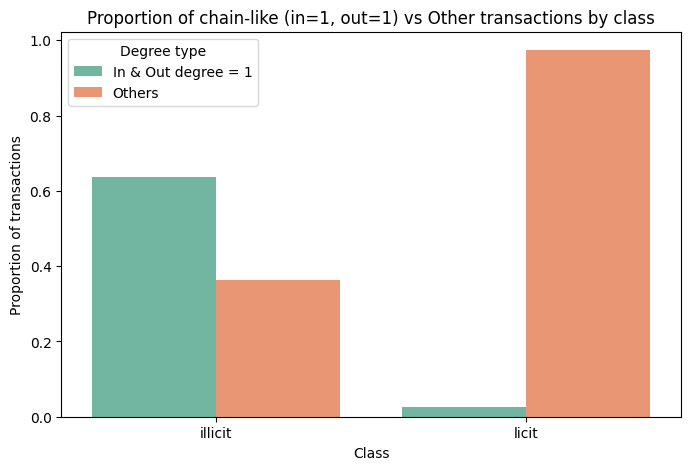

In [54]:
in_out_df = tx_df.copy()

# Create categorical column: in_degree=1 and out_degree=1
in_out_df['degree_type'] = np.where(
    (in_out_df['num_input_addresses'] == 1) & (in_out_df['num_output_addresses'] == 1),
    'In & Out degree = 1',
    'Others')

in_out_df_filtered = in_out_df[in_out_df['class_mapped'] != 'unknown'].copy()
counts = (in_out_df_filtered.groupby(['class_mapped', 'degree_type']).size().reset_index(name='count'))
counts['proportion'] = counts.groupby('class_mapped')['count'].transform(lambda x: x / x.sum())

plt.figure(figsize=(8,5))
sns.barplot(data=counts, x='class_mapped',y='proportion',hue='degree_type',palette='Set2')

plt.ylabel("Proportion of transactions")
plt.xlabel("Class")
plt.title("Proportion of chain-like (in=1, out=1) vs Other transactions by class")
plt.legend(title="Degree type")
plt.show()

This shows that illicit wallets have a higher proportion of nodes with In and Out-degrees equals to 1, highlighting possible **peel chain behaviour** as well.

**For high and low in and out degrees**

The degree distributions are heavy-tailed, hence to identify nodes with unusually low or high activity without being overly influenced by extreme outliers, we use the 10th and 95th percentile as thresholds rather than standard deviation–based methods.

In [55]:
# Get upper and lower Q of degrees

# Compute quartiles
in_low = in_out_df['num_input_addresses'].quantile(0.25)
in_high = in_out_df['num_input_addresses'].quantile(0.75)

out_low = in_out_df['num_output_addresses'].quantile(0.25)
out_high = in_out_df['num_output_addresses'].quantile(0.75)

print(f"In-degree: Q1={in_low}, Q3={in_high}")
print(f"Out-degree: Q1={out_low}, Q3={out_high}")

In-degree: Q1=1.0, Q3=1.0
Out-degree: Q1=2.0, Q3=2.0


In [56]:
# Input categories
in_out_df['input_degree_type'] = np.where(
    in_out_df['num_input_addresses'] <= in_low, 'Low input',
    np.where(in_out_df['num_input_addresses'] >= in_high, 'High input', 'Ignore'))

# Output categories
in_out_df['output_degree_type'] = np.where(
    in_out_df['num_output_addresses'] <= out_low, 'Low output',
    np.where(in_out_df['num_output_addresses'] >= out_high, 'High output', 'Ignore'))

# Combine input/output categories
in_out_df['degree_type'] = (
    in_out_df['input_degree_type'].str.replace(' input', '') + ' / ' +
    in_out_df['output_degree_type'].str.replace(' output', ''))

# Filter out unknowns and ignored categories
in_out_df_filtered = in_out_df[(in_out_df['class_mapped'] != 'unknown')]

# Aggregate counts and proportions
counts = (
    in_out_df_filtered.groupby(['class_mapped', 'degree_type'])
    .size()
    .reset_index(name='count'))

counts['proportion'] = counts.groupby('class_mapped')['count'].transform(
    lambda x: x / x.sum())

degree_order = ['Low / Low', 'Low / High', 'High / Low', 'High / High']
class_order = in_out_df_filtered['class_mapped'].unique()

# Ensure every class × degree_type combination is present
all_combinations = pd.MultiIndex.from_product([class_order, degree_order],names=['class_mapped', 'degree_type'])

counts = (counts.set_index(['class_mapped', 'degree_type'])
    .reindex(all_combinations, fill_value=0)
    .reset_index())

counts['proportion'] = counts.groupby('class_mapped')['count'].transform(lambda x: x / x.sum())


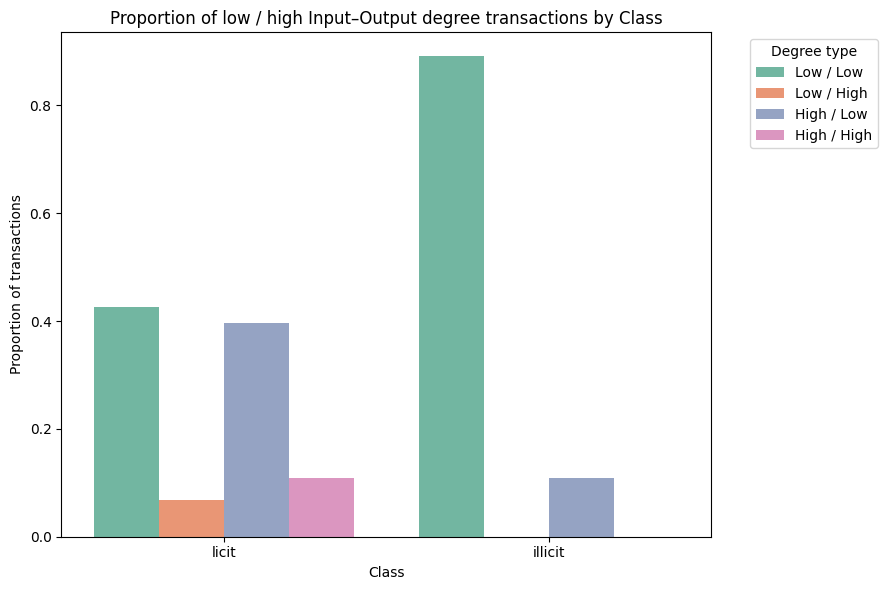

In [57]:
plt.figure(figsize=(9, 6))
sns.barplot(
    data=counts,
    x='class_mapped',
    y='proportion',
    hue='degree_type',
    hue_order=degree_order,
    palette='Set2')

plt.ylabel("Proportion of transactions")
plt.xlabel("Class")
plt.title("Proportion of low / high Input–Output degree transactions by Class")
plt.legend(title="Degree type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [58]:
illicit = in_out_df[in_out_df['class_mapped'] == 'illicit']

print("Illicit below 10% inputs:", (illicit['num_input_addresses'] <= in_low).sum())
print("Illicit above 95% inputs:", (illicit['num_input_addresses'] >= in_high).sum())

print("Illicit below 10% outputs:", (illicit['num_output_addresses'] <= out_low).sum())
print("Illicit above 95% outputs:", (illicit['num_output_addresses'] >= out_high).sum())


Illicit below 10% inputs: 4050
Illicit above 95% inputs: 4545
Illicit below 10% outputs: 4543
Illicit above 95% outputs: 1595


# 7. Export `tx_df` with engineered features for modelling
Export `tx_df.csv` which contains feature engineering to proceed with model training in another notebook.

In [59]:
# Adjust to be same as other datasets
tx_df.drop({'class_mapped', 'class'}, axis=1, inplace=True)

In [60]:
tx_df.rename({'tx_id': 'txId'}, axis=1).to_csv('txs_feature_engineered.csv', index=False)

In [61]:
save_path = './data/tx_df.csv'
tx_df.to_csv(save_path, index=False)